In [34]:
import os
import sys
sys.path.append("../src")

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

import utils as u

In [36]:
u.graph_setting()

In [2]:
# make initial matrix
def make_ini_mat():

    # simulated square map
    x = np.arange(32)
    y = np.arange(32)
    xc = np.max(x)/2
    yc = np.max(y)/2
    

    # make matrix
    mat = pd.DataFrame({"X":[], "Y":[]})
    for x_ in x:
        for y_ in y:
            r = res_r(x_, y_, xc, yc)
            if r+0.5<xc:
                mat = pd.concat([mat, pd.DataFrame({"X":x_, "Y":y_}, index=[0])])
    # reset index
    mat = mat.reset_index(drop=True)

    return mat

def res_r(x, y, xc, yc):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

In [3]:
# select initial fails
def random_fail(mat:pd.DataFrame, fail_count:int):

    # fail = 0, pass = 1

    # random index
    rand_idx = np.random.permutation(len(mat))

    # select fail index
    rand_idx = rand_idx[:fail_count]

    # make pass s
    pass_flgs = np.ones(len(mat))

    # fail select
    for i in rand_idx:
        pass_flgs[i] = 0

    # add matrix
    mat["Pass"] = pass_flgs
    mat["Pass"] = mat["Pass"].astype("int")

    return mat

In [4]:
# random dust
def random_dust(dust_count:int, x_range:list, y_range:list):

    # r and s
    r = x_range[1]/2
    # center
    xc = x_range[1]/2
    yc = y_range[1]/2

    # x_list and y_list
    x_list = []
    y_list = []

    while len(x_list)<dust_count:
        # sampling
        # random x
        xs = scipy.stats.uniform.rvs(loc=x_range[0], scale=x_range[1] ,size=1)[0]
        # random y
        ys = scipy.stats.uniform.rvs(loc=y_range[0], scale=y_range[1] ,size=1)[0]
        # calc r
        samp_r = res_r(xs, ys, xc, yc)
        # check r range
        if samp_r <= r:
            x_list.append(xs)
            y_list.append(ys)

    out = pd.DataFrame({"x":x_list, "y":y_list})

    return out

In [5]:
# count dust in each chips
def count_dust(mat, rdust):

    dust_cnts = []

    # count each chip
    for idx, items in mat.iterrows():
        # tip
        xc = items[0]
        yc = items[1]

        # check each x, y dust
        count = len(rdust[(rdust["x"]>=xc-0.5)&(rdust["x"]<xc+0.5)&(rdust["y"]>=yc-0.5)&(rdust["y"]<yc+0.5)])
        dust_cnts.append(count)

    mat["Dust_count"] = dust_cnts

    return mat

In [6]:
# Judge fail or pass by KR
def res_fail_or_pass(KR:float, count:int):
    # initial
    res = 0
    # judge by KR
    for cycle in range(count):
        if np.random.random()<KR:
            res = 1
        else:
            if res==1:
                break
            else:
                res = 0
    return res

# calc Pass Ratio
def calc_PassRatio(mat_result:pd.DataFrame):

    # pass chips
    pass_df = mat_result[mat_result["Pass"]==1]

    # pass
    pass_size = len(pass_df)
    # killed
    kill_size = len(pass_df[pass_df["Kill"]==1])

    # Pass ratio
    pass_ratio = (pass_size - kill_size)/pass_size

    return pass_ratio

In [27]:
def SimPassRatio(initial_fail_count, dust_count, KR):

    # make initial matrix
    mat = make_ini_mat()

    # pass from previous test
    mat = random_fail(mat, initial_fail_count)

    # make random dust
    rdust = random_dust(dust_count=dust_count, x_range=[0,30], y_range=[0,30])

    # count dust
    mat = count_dust(mat, rdust)

    # add kill flg
    mat["Kill"] = [res_fail_or_pass(KR=KR, count=cnt) if cnt!=0 else 0 for cnt in mat["Dust_count"]]

    # calc PassRatio
    pass_ratio = calc_PassRatio(mat)

    return pass_ratio

# Make data

In [153]:
# initial matrix
mat = make_ini_mat()
print(mat.shape)
mat.head()

(716, 2)


X     Y
0  1.0  12.0
1  1.0  13.0
2  1.0  14.0
3  1.0  15.0
4  1.0  16.0

In [154]:
# add inital fail
fail_count = 100
mat = random_fail(mat, fail_count)
mat.head()

X     Y  Pass
0  1.0  12.0     1
1  1.0  13.0     1
2  1.0  14.0     1
3  1.0  15.0     1
4  1.0  16.0     0

(200, 2)


(0.0, 30.0)

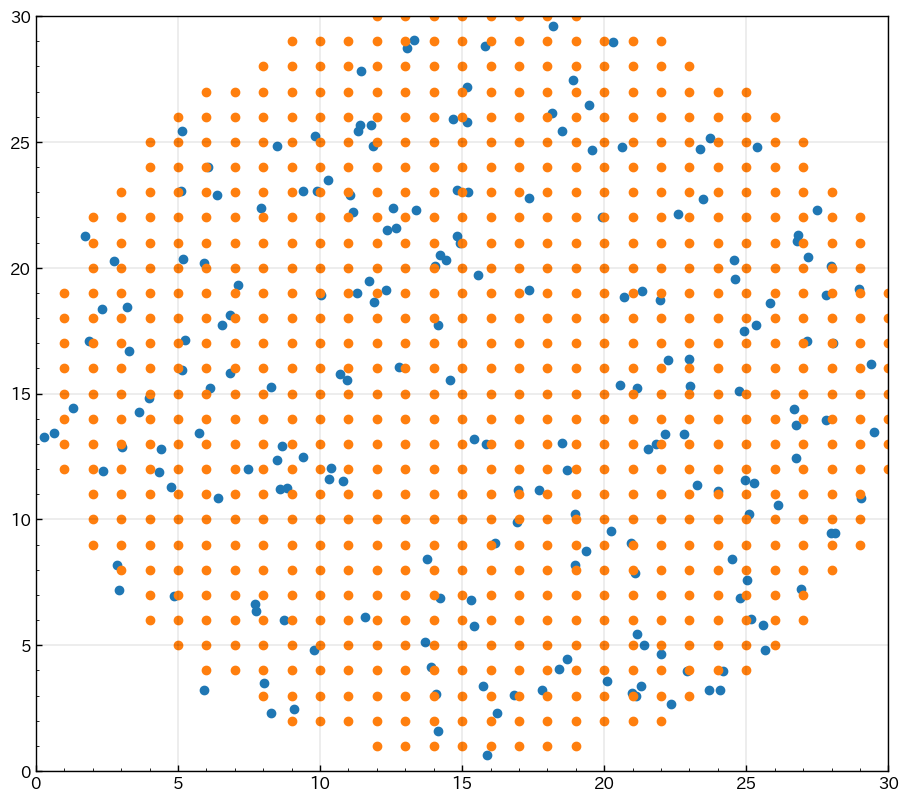

In [155]:
rdust = random_dust(dust_count=200, x_range=[0,30], y_range=[0,30])
print(rdust.shape)
plt.figure(figsize=(11,10))
plt.scatter(rdust.x, rdust.y)
plt.scatter(mat.X, mat.Y)
plt.xlim([0,30])
plt.ylim([0,30])

In [156]:
# 集約してダストの数を数えて追加していく
mat = count_dust(mat, rdust)

In [157]:
mat["Kill"] = [res_fail_or_pass(KR=0.12, count=cnt) if cnt!=0 else 0 for cnt in mat["Dust_count"]]
mat.head()

X     Y  Pass  Dust_count  Kill
0  1.0  12.0     1           0     0
1  1.0  13.0     1           1     0
2  1.0  14.0     1           1     0
3  1.0  15.0     1           0     0
4  1.0  16.0     0           0     0

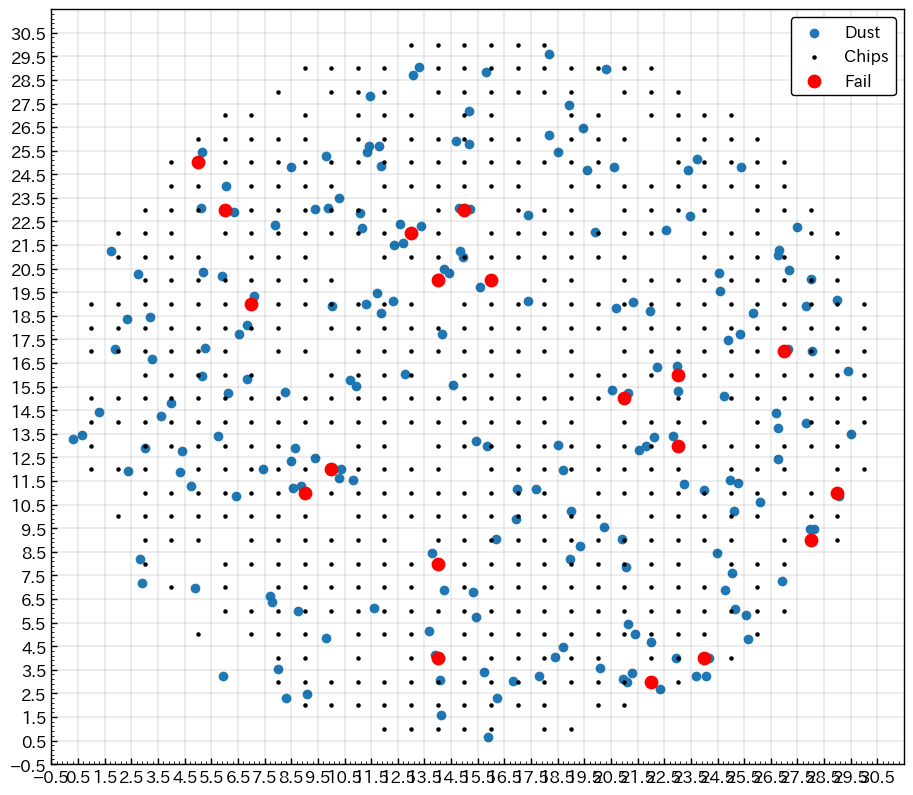

In [158]:
plt.figure(figsize=(11,10))
plt.scatter(rdust.x, rdust.y, label="Dust")
plt.scatter(mat[mat["Pass"]==1].X, mat[mat["Pass"]==1].Y, c="black", s=5, label="Chips")
plt.scatter(mat[mat["Kill"]==1].X, mat[mat["Kill"]==1].Y, c="red", s=80, label="Fail")
plt.xlim([-0.5,31.5])
plt.ylim([-0.5,31.5])
plt.grid(True, which='major', linewidth=0.1)
plt.xticks(np.arange(32)-0.5)
plt.yticks(np.arange(32)-0.5)
plt.legend();

In [41]:
np.arange(30)-0.5

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
       21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5])

In [26]:
calc_PassRatio(mat)

0.9951298701298701

In [15]:
from tqdm import tqdm
# Simulation
dust_count = np.arange(10, 500, 20)
KR = 1.0

# exe sim
dust_count_result = []
passr_result = []

for d in tqdm(dust_count):
    for i in range(10):
        init_fc = np.random.randint(400)
        pr = SimPassRatio(initial_fail_count=init_fc, dust_count=d, KR=KR)

        dust_count_result.append(d)
        passr_result.append(pr)

100%|██████████| 25/25 [03:44<00:00,  8.97s/it]


Text(0, 0.5, 'Pass Rate(%)')

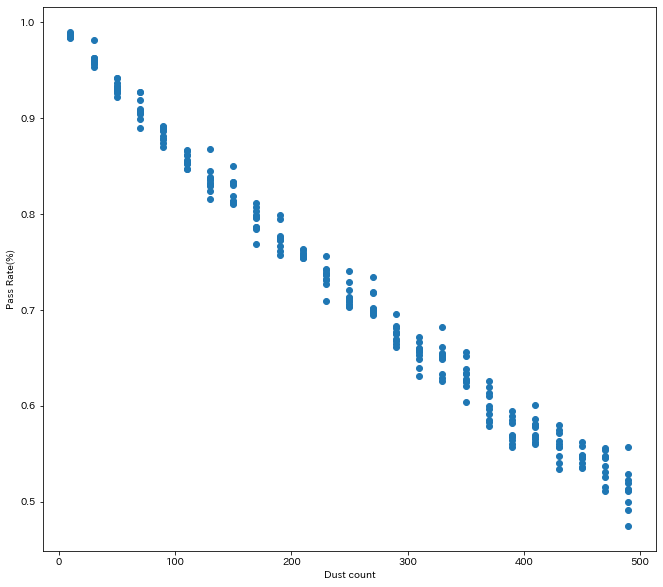

In [16]:
plt.figure(figsize=(11,10))
plt.scatter(dust_count_result, passr_result)
plt.xlabel("Dust count")
plt.ylabel("Pass Rate(%)")

In [32]:
# Simulation
dust_count = np.arange(0, 2000, 50)
KR = [1.0, 0.75, 0.5, 0.25, 0.01]

result = pd.DataFrame({})

for kr in KR:
    # exe sim
    dust_count_result = []
    passr_result = []

    for d in tqdm(dust_count):
        for i in range(1):
            init_fc = 100 #np.random.randint(600)
            pr = SimPassRatio(initial_fail_count=init_fc, dust_count=d, KR=kr)

            dust_count_result.append(d)
            passr_result.append(pr)

    result = pd.concat([result,
                        pd.DataFrame({"DustCount":dust_count_result,
                                      "PassRatio":passr_result,
                                      "KR":kr})])

100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


(-0.02, 1.02)

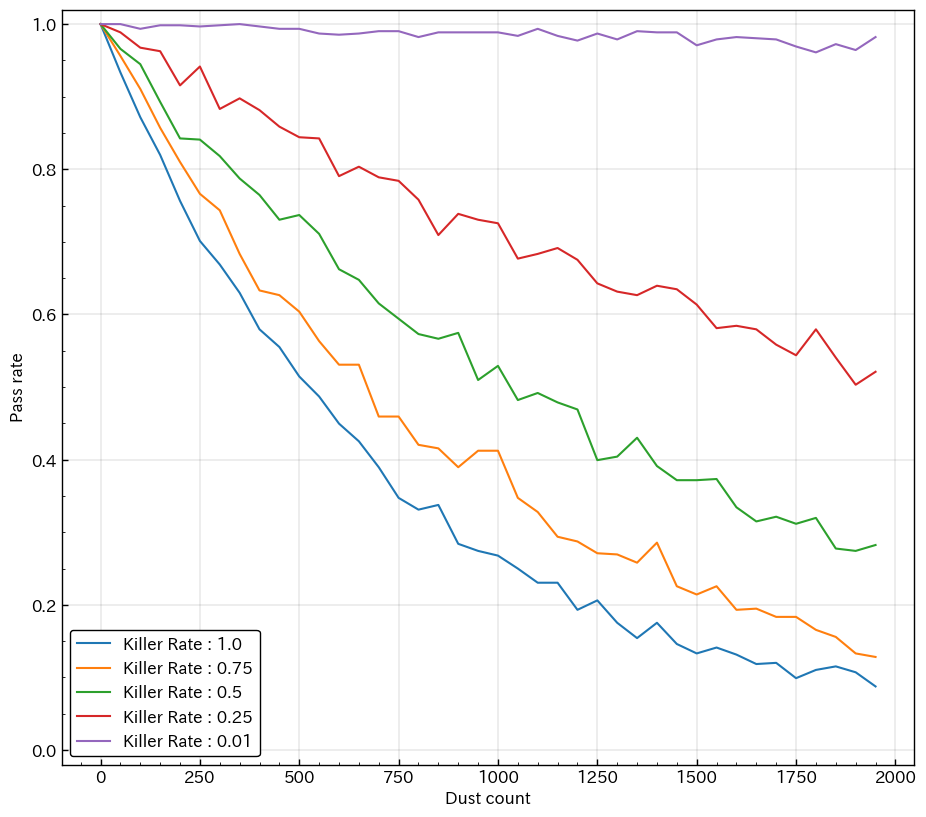

In [37]:
plt.figure(figsize=(11,10))

for kr in KR:
    # slice each killer rate
    result_ = result[result["KR"]==kr]
    dc = result_["DustCount"].values
    pr = result_["PassRatio"].values
    # plot
    plt.plot(dc, pr, label = f"Killer Rate : {kr}")

plt.legend()
plt.xlabel("Dust count")
plt.ylabel("Pass rate")
plt.ylim([-0.02,1.02])

# With class

In [159]:
import KR_sim_model as ksm

import importlib
importlib.reload(ksm)

<module 'KR_sim_model' from 'c:\\Users\\yktkk\\Desktop\\DS_practice\\Data_science\\Work\\KR_prediction_model\\notebook\\../src\\KR_sim_model.py'>

In [149]:
# simple
fail_count_list = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
sim = ksm.SimPassRatio(x_max=32, y_max=32)

In [150]:
result = ksm.exe(fail_count_list)

(-0.02, 1.02)

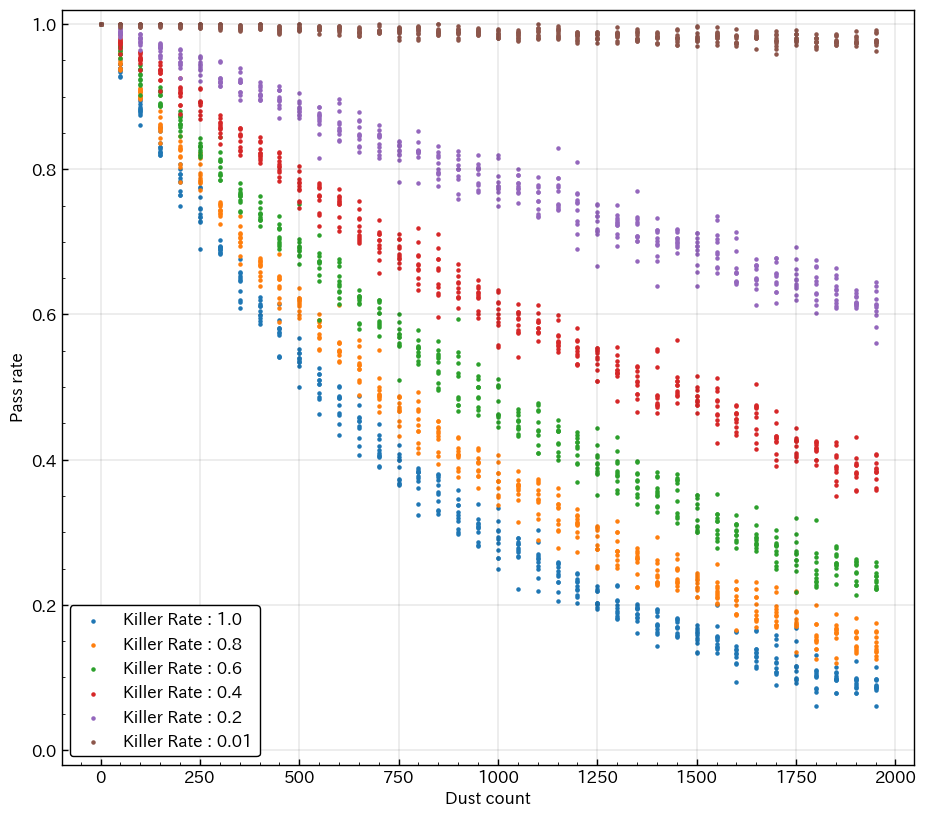

In [152]:
# plot
unique_kr = result["killer_rate"].unique()

plt.figure(figsize=(11,10))
for kr in unique_kr:

    # slice each killer rate
    result_ = result[result["killer_rate"]==kr]
    dc = result_["dust_count"].values
    pr = result_["pass_rate"].values
    # plot
    plt.scatter(dc, pr, label = f"Killer Rate : {kr}", s=5)

plt.legend()
plt.xlabel("Dust count")
plt.ylabel("Pass rate")
plt.ylim([-0.02,1.02])

## Visualization

In [230]:
import importlib
importlib.reload(ksm)

<module 'KR_sim_model' from 'c:\\Users\\yktkk\\Desktop\\DS_practice\\Data_science\\Work\\KR_prediction_model\\notebook\\../src\\KR_sim_model.py'>

In [231]:
sim = ksm.SimPassRatio(x_max=32, y_max=32)

In [232]:
sim.mat.to_csv(r"C:\Users\yktkk\Desktop\DS_practice\Data_science\Work\KR_prediction_model\notebook\test.csv")

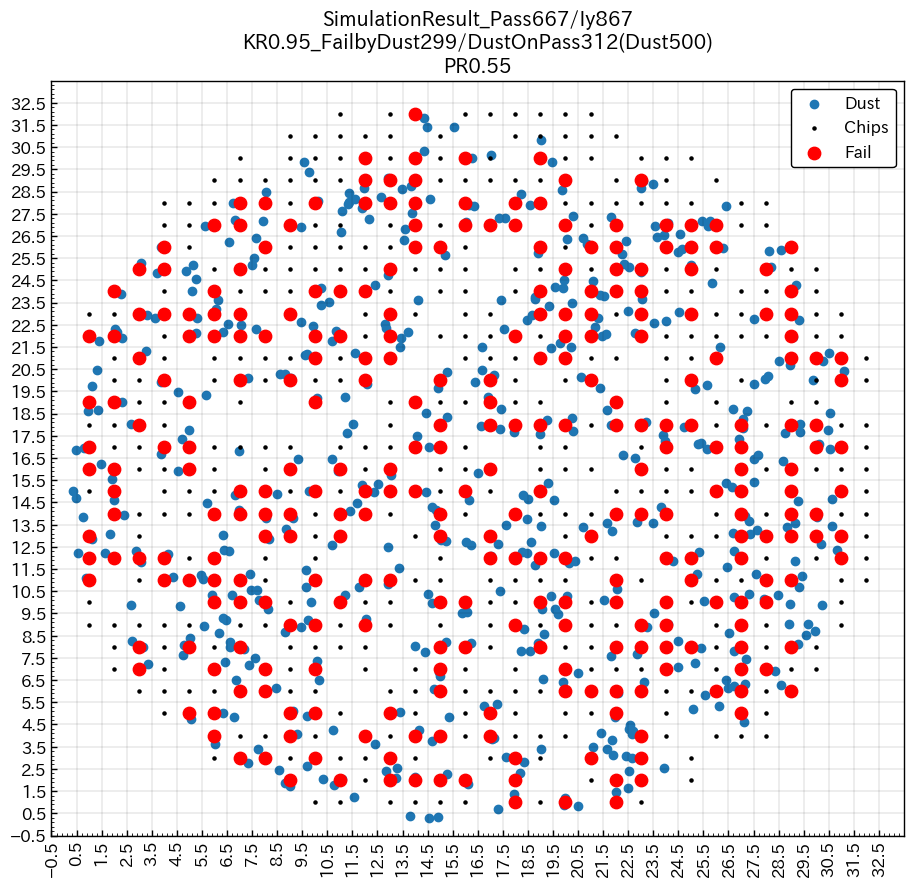

In [234]:
fc = 200
dc = 500
kr = 0.95

sim.sample_each_result(fc, dc, kr)
sim.mat.to_csv(r"C:\Users\yktkk\Desktop\DS_practice\Data_science\Work\KR_prediction_model\notebook\test.csv")